#Part 2 - Snowing Cats and Dogs
We'll use convolutional neural networks to predict whether a picture is of a cat or a dog. We'll begin with some imports

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from numpy import asarray, save, load
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib.pyplot import imshow
from PIL import Image
import matplotlib.pyplot as plt
from shutil import copy, move
from sklearn.model_selection import train_test_split

The images are all in 1 folder. We need to make a train/validation split. I've decided to use directory based typing, so we need 1 directory each for training / validation and 1 subdirectory each for cat vs. dog

In [2]:
# files loaded to colab
train_dir = '/content/drive/MyDrive/MSDS_422/assignment-3-part-2-training-images/'
test_dir = '/content/drive/MyDrive/MSDS_422/assignment-3-part-2-test-images/'
# files redistributed to train/val cat/dog based on split and image name
target_dir = '/content/drive/MyDrive/MSDS_422/A3P2/'

In [ ]:
tv_img = os.listdir(train_dir) # list files
imgT, imgV = train_test_split(tv_img, test_size = 0.2, random_state = 21) #split

for dir in ['train', 'train/cat', 'train/dog', 
            'valid', 'valid/cat', 'valid/dog']: # make directories
  try: 
    os.mkdir(os.path.join(target_dir, dir)) 
  except FileExistsError: 
    pass

# we'll use directory-based class calling
for file_name in imgT:
  if file_name[-4:] == '.jpg': # if image
    animal = file_name[0:3] # use animal to target
    copy(os.path.join(train_dir, file_name), #move image
          os.path.join(target_dir, 'train', animal, file_name)) 

for file_name in imgV: # copy the validation images
  if file_name[-4:] == '.jpg':
    animal = file_name[0:3] # use animal to target
    copy(os.path.join(train_dir, file_name), 
          os.path.join(target_dir, 'valid', animal, file_name)) 

In [4]:
len(os.listdir(os.path.join(target_dir, 'valid', 'cat'))) # 510
len(os.listdir(os.path.join(target_dir, 'train', 'cat'))) # 2000 - ok




2000

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# generators
train_gen = ImageDataGenerator(rescale=1./255) # convert to float32 0-1
val_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    os.path.join(target_dir, 'train'),
    target_size=(200,200), # images are 200x200, if not will get rescaled
    batch_size=32,
    class_mode='binary' # cat vs. dog
    )

validate_generator = val_gen.flow_from_directory(
    os.path.join(target_dir, 'valid'),
    target_size=(200,200),
    batch_size=32,
    class_mode='binary'
    )

Found 4007 images belonging to 2 classes.
Found 1003 images belonging to 2 classes.


# model set up
we'll set up a convoltional neural network to classify cats vs. dogs. I've played with this to build a model that is good, not great.

In [6]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import mixed_precision # some 16 + some 32 = faster
mixed_precision.set_global_policy('mixed_float16') 
  #https://www.tensorflow.org/guide/mixed_precision


# not so simple CNN:
# 6 convolutional layers with pooling between. 1st layer has a fairly large 
# kernel of 7 x 7, with conventional increasing numbers of filters
# this is flattened and then goes to fully connected layers
model=models.Sequential([
    layers.Input(shape = (200,200,3)),
    layers.Conv2D(32, (7,7), activation = 'relu'),
    layers.Conv2D(32, (3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(3,3),strides=(3,3)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(3,3),strides=(3,3)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(3,3),strides=(3,3)),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1,activation='sigmoid') # 1 neuron - binary
    ])
model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 194, 194, 32)      4736      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        36928     
____________________________

In [7]:
model.compile(loss='binary_crossentropy', # as this is binary
             optimizer=optimizers.RMSprop(lr=1e-4), # reasonable
             metrics=['acc']) # also reasonable

In [8]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data = validate_generator
    )

Epoch 1/10
126/126 [==============================] - 1941s 15s/step - loss: 0.6904 - acc: 0.5134 - val_loss: 0.6806 - val_acc: 0.5713
Epoch 2/10
126/126 [==============================] - 21s 165ms/step - loss: 0.6675 - acc: 0.5891 - val_loss: 0.6400 - val_acc: 0.6301
Epoch 3/10
126/126 [==============================] - 21s 163ms/step - loss: 0.6363 - acc: 0.6363 - val_loss: 0.6299 - val_acc: 0.6431
Epoch 4/10
126/126 [==============================] - 21s 166ms/step - loss: 0.5966 - acc: 0.6868 - val_loss: 0.6168 - val_acc: 0.6600
Epoch 5/10
126/126 [==============================] - 21s 165ms/step - loss: 0.5953 - acc: 0.6643 - val_loss: 0.5974 - val_acc: 0.6800
Epoch 6/10
126/126 [==============================] - 21s 168ms/step - loss: 0.5481 - acc: 0.7191 - val_loss: 0.5699 - val_acc: 0.7009
Epoch 7/10
126/126 [==============================] - 21s 169ms/step - loss: 0.5275 - acc: 0.7562 - val_loss: 0.5644 - val_acc: 0.7238
Epoch 8/10
126/126 [==============================] - 2

In [9]:
print(history.history['acc']) # 0.893
print(history.history['val_acc']) # 0.816 - overfitting somewhat - good
model.save('/content/dog_cat_model_1.h5')

[0.5393062233924866, 0.5999500751495361, 0.6496132016181946, 0.6835537552833557, 0.686798095703125, 0.7152482867240906, 0.7481906414031982, 0.7506862878799438, 0.7699026465415955, 0.7881208062171936]
[0.571286141872406, 0.6301096677780151, 0.6430708169937134, 0.6600199341773987, 0.6799601316452026, 0.7008973360061646, 0.7238284945487976, 0.7357926368713379, 0.7258225083351135, 0.7387836575508118]


Well, that was OK. Next we'll try varying the architecture to make a better network. I tried [keras-tuner](https://keras-team.github.io/keras-tuner/), but there's not a good way to time it. Also, it still ended up looking quite ugly because of the need to add multiple batchNorm or dropout layers, so I just did it as a function.

In [10]:
from tensorflow.keras.constraints import max_norm
# max_norm implements max_norm weight based regularization
# caps the sum of weights for each layer and redistributes

def build_model(bn=False, dropout=False, use_max_norm=False):
    if use_max_norm: kernal_constraint = max_norm(2.)
    else: kernal_constraint = None

    model = models.Sequential()
    model.add(layers.Input(shape = (200,200,3))) # input
    if bn: model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (7,7), activation = 'relu'))
    if bn: model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
    if bn: model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(3,3)))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    if bn: model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    if bn: model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(3,3)))
    if bn: model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    if bn: model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    if bn: model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(3,3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256,activation='relu', 
                           kernel_constraint=kernal_constraint))
    if bn: model.add(layers.BatchNormalization())
    if dropout: model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation = 'relu',
                           kernel_constraint=kernal_constraint))
    if bn: model.add(layers.BatchNormalization())
    if dropout: model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation='sigmoid'))
    
    
    model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['accuracy'])
    return model

In [11]:
# setup - typically keras shuffles data (randomly) and layers are randomly
# initialized. Here is some code to fix that. 
# Source: https://keras.io/getting_started/faq/
import random as python_random

!PYTHONHASHSEED=0
np.random.seed(21)
python_random.seed(21)
tf.random.set_seed(21)

from timeit import default_timer as timer # timing program
                        #batch_norm, dropout, use_max_norm
variants = {'baseline':[  False,     False,    False],
            'batch_norm':[True,      False,    False],
            'dropout':   [False,     True,     False],
            'max_norm':  [False,     False,    True]}
            
resList=[] # for storing our results
resToPlot = [] # for making a graph
for variant in variants.keys():
  print()

  start = timer()
  var_model = build_model(variants[variant]) #including build time
  history = var_model.fit(
      train_generator,
      epochs=20, # better look at overfitting if it's happening
      verbose = 0, # printing raises fitting time non-uniformly
      validation_data = validate_generator
      )
  end = timer()
  elapsed = end - start
  resList.append({'model': variant,
    'val_accuracy':history.history['val_accuracy'][-1],
    'train_accuracy':history.history['accuracy'][-1],
    'train_val_time':elapsed})
  resToPlot.append({'model':variant, 
          'val_accs':history.history['val_accuracy'],
          'train_accs': history.history['accuracy']})

result = pd.DataFrame(resList)
result

,model,val_accuracy,train_accuracy,train_val_time
0,baseline,0.748754,0.992264,481.921144
1,batch_norm,0.763709,0.993012,480.554623
2,dropout,0.740778,0.991515,480.699108
3,max_norm,0.736790,0.993012,483.295973


These variations seem to have minimal impact on validation or training accuracy. That is, these regularizers are not doing much regularization

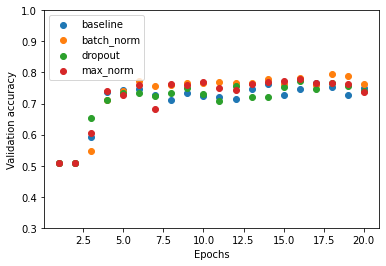

In [13]:
labels = []
fig, ax = plt.subplots()
for result in resToPlot:
  plt.scatter(range(1,21), result['val_accs'])
  labels.append(result['model'])
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
ax.set_ylim(0.30, 1)
plt.legend(labels=labels)

We quickly get a boost in validation accuracy, but then plateau. There's mild evidence of overfitting at 20 epochs. An early stopping strategy would also be some good regularizing.